In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

from gseapy import Msigdb
import decoupler as dc
import gseapy as gp
from gseapy import barplot, dotplot
import scFates as scf
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from adjustText import adjust_text
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

In [5]:
adata_ker = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/KC_PPP_10X.h5ad')

In [6]:
adata_ker.obs['batch_group'] = adata_ker.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_ker.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

df_name = adata_ker.obs['batch'].astype(str).str.split("_", expand=True)
df_name.loc[df_name.index.str.contains('PPP'), 1] = df_name.loc[df_name.index.str.contains('PPP'), 1].str.split("C", expand=True)[0]
df_name = df_name[0] + '_' + df_name[1]
# df_name.str.split("C", expand=True)[0]
# df_name[df_name.index.str.contains('PPP_')] = df_name[df_name.index.str.contains('PPP')].str.split("C", expand=True)[0]
adata_ker.obs['patient'] = df_name.copy()
adata_ker.obs['patient'].value_counts()

adata_ker.obs['leiden'] = adata_ker.obs['leiden'].cat.reorder_categories(['Basal KC I', 'Basal KC II', 'Basal KC III', 'Suprabasal KC I', 
                                            'Suprabasal KC II', 'Proliferating KC', 'Stressed KC'])

def map_cell_type(leiden):
    if "Suprabasal" in leiden:
        return "Suprabasal"
    elif "Basal" in leiden:
        return "Basal"
    elif "Stressed" in leiden:
        return "Stressed"
    elif "Proliferating" in leiden:
        return "Proliferating"
    else:
        assert False, f"Unknown cell type: {leiden}"

adata_ker.obs['cell_type'] = adata_ker.obs['leiden'].apply(map_cell_type)
adata_ker.obs['meta_cell_type'] = adata_ker.obs['Meta'].astype(str) + '_' + adata_ker.obs['cell_type'].astype(str)
adata_ker.obs['batch_group_cell_type'] = adata_ker.obs['batch_group'].astype(str) + '_' + adata_ker.obs['cell_type'].astype(str)

### pseudo bulk

In [7]:
pdata = dc.get_pseudobulk(
    adata_ker,
    sample_col='batch',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

In [8]:
MetaData = pd.read_csv("charts/metadata.csv", index_col=0)
MetaData
# update metadata
pdata.obs = pdata.obs.join(MetaData, how='left', on='batch')
pdata.obs.columns

Index(['batch', 'batch_origin', 'batch_group', 'Meta', 'is_P36', 'is_C02_palm',
       'is_C02_foot', 'is_P40', 'is_P29', 'is_P23', 'patient', 'cell_type',
       'meta_cell_type', 'batch_group_cell_type', 'psbulk_n_cells',
       'psbulk_counts', 'Gender', 'Age'],
      dtype='object')

In [9]:
pdata.layers['counts'] = pdata.X.copy()

sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

basal_cell = pdata[pdata.obs['cell_type'] == 'Basal']
suprabasal_cell = pdata[pdata.obs['cell_type'] == 'Suprabasal']

normalizing counts per cell
    finished (0:00:00)


In [10]:
msig = Msigdb()
gmt_go_bp = msig.get_gmt(category="c5.go.bp", dbver='2023.2.Hs')
gmt_hallmark = msig.get_gmt(category="h.all", dbver='2023.2.Hs')

il17_pathway_set = {'GOBP_RESPONSE_TO_INTERLEUKIN_17': gmt_go_bp['GOBP_RESPONSE_TO_INTERLEUKIN_17']}
jak_stat_pathway_set = {'HALLMARK_IL6_JAK_STAT3_SIGNALING': gmt_hallmark['HALLMARK_IL6_JAK_STAT3_SIGNALING']}

intersect_genes = set(il17_pathway_set['GOBP_RESPONSE_TO_INTERLEUKIN_17']) & set(jak_stat_pathway_set['HALLMARK_IL6_JAK_STAT3_SIGNALING'])

il17_pathway_set_unique = {'GOBP_RESPONSE_TO_INTERLEUKIN_17_UNIQUE': list(set(il17_pathway_set['GOBP_RESPONSE_TO_INTERLEUKIN_17']) - intersect_genes)}
jak_stat_pathway_set_unique = {'HALLMARK_IL6_JAK_STAT3_SIGNALING_UNIQUE': list(set(jak_stat_pathway_set['HALLMARK_IL6_JAK_STAT3_SIGNALING']) - intersect_genes)}

# GOBP_KERATINOCYTE_DIFFERENTIATION
keratinocyte_diff_pathway_set = {'GOBP_KERATINOCYTE_DIFFERENTIATION': gmt_go_bp['GOBP_KERATINOCYTE_DIFFERENTIATION']}
# GOBP_KERATINOCYTE_PROLIFERATION
keratinocyte_proliferation_pathway_set = {'GOBP_KERATINOCYTE_PROLIFERATION': gmt_go_bp['GOBP_KERATINOCYTE_PROLIFERATION']}

es_il17 = gp.gsva(data=basal_cell.to_df().T, # row -> genes, column-> samples
             gene_sets=il17_pathway_set,
             outdir=None,
             min_size=3,
            #  mx_diff=False,
             )

es_il17_unique = gp.gsva(data=basal_cell.to_df().T, # row -> genes, column-> samples
             gene_sets=il17_pathway_set_unique,
             outdir=None,
             min_size=1,
            #  mx_diff=False,
             )

es_jak_stat = gp.gsva(data=basal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=jak_stat_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

es_jak_stat_unique = gp.gsva(data=basal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=jak_stat_pathway_set_unique,
                outdir=None,
                # mx_diff=False,
                )

es_keratinocyte_diff = gp.gsva(data=basal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=keratinocyte_diff_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

es_keratinocyte_proliferation = gp.gsva(data=basal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=keratinocyte_proliferation_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

df_list = []
df_list.append(es_il17.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_IL17'}))
df_list.append(es_il17_unique.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_IL17_UNIQUE'}))
df_list.append(es_jak_stat.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_JAK_STAT'}))
df_list.append(es_jak_stat_unique.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_JAK_STAT_UNIQUE'}))
df_list.append(es_keratinocyte_diff.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_KERATINOCYTE_DIFF'}))
df_list.append(es_keratinocyte_proliferation.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_KERATINOCYTE_PROLIFERATION'}))

merged_df = pd.concat(df_list, axis=1, join='outer')
merged_df = merged_df.join(basal_cell.obs, how='left')
# merged_df

KeyboardInterrupt: 

/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:5.245e-03 U_stat=6.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.643e-02 U_stat=9.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.154e-02 U_stat=8.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.105e-01 U_stat=1.900e+01


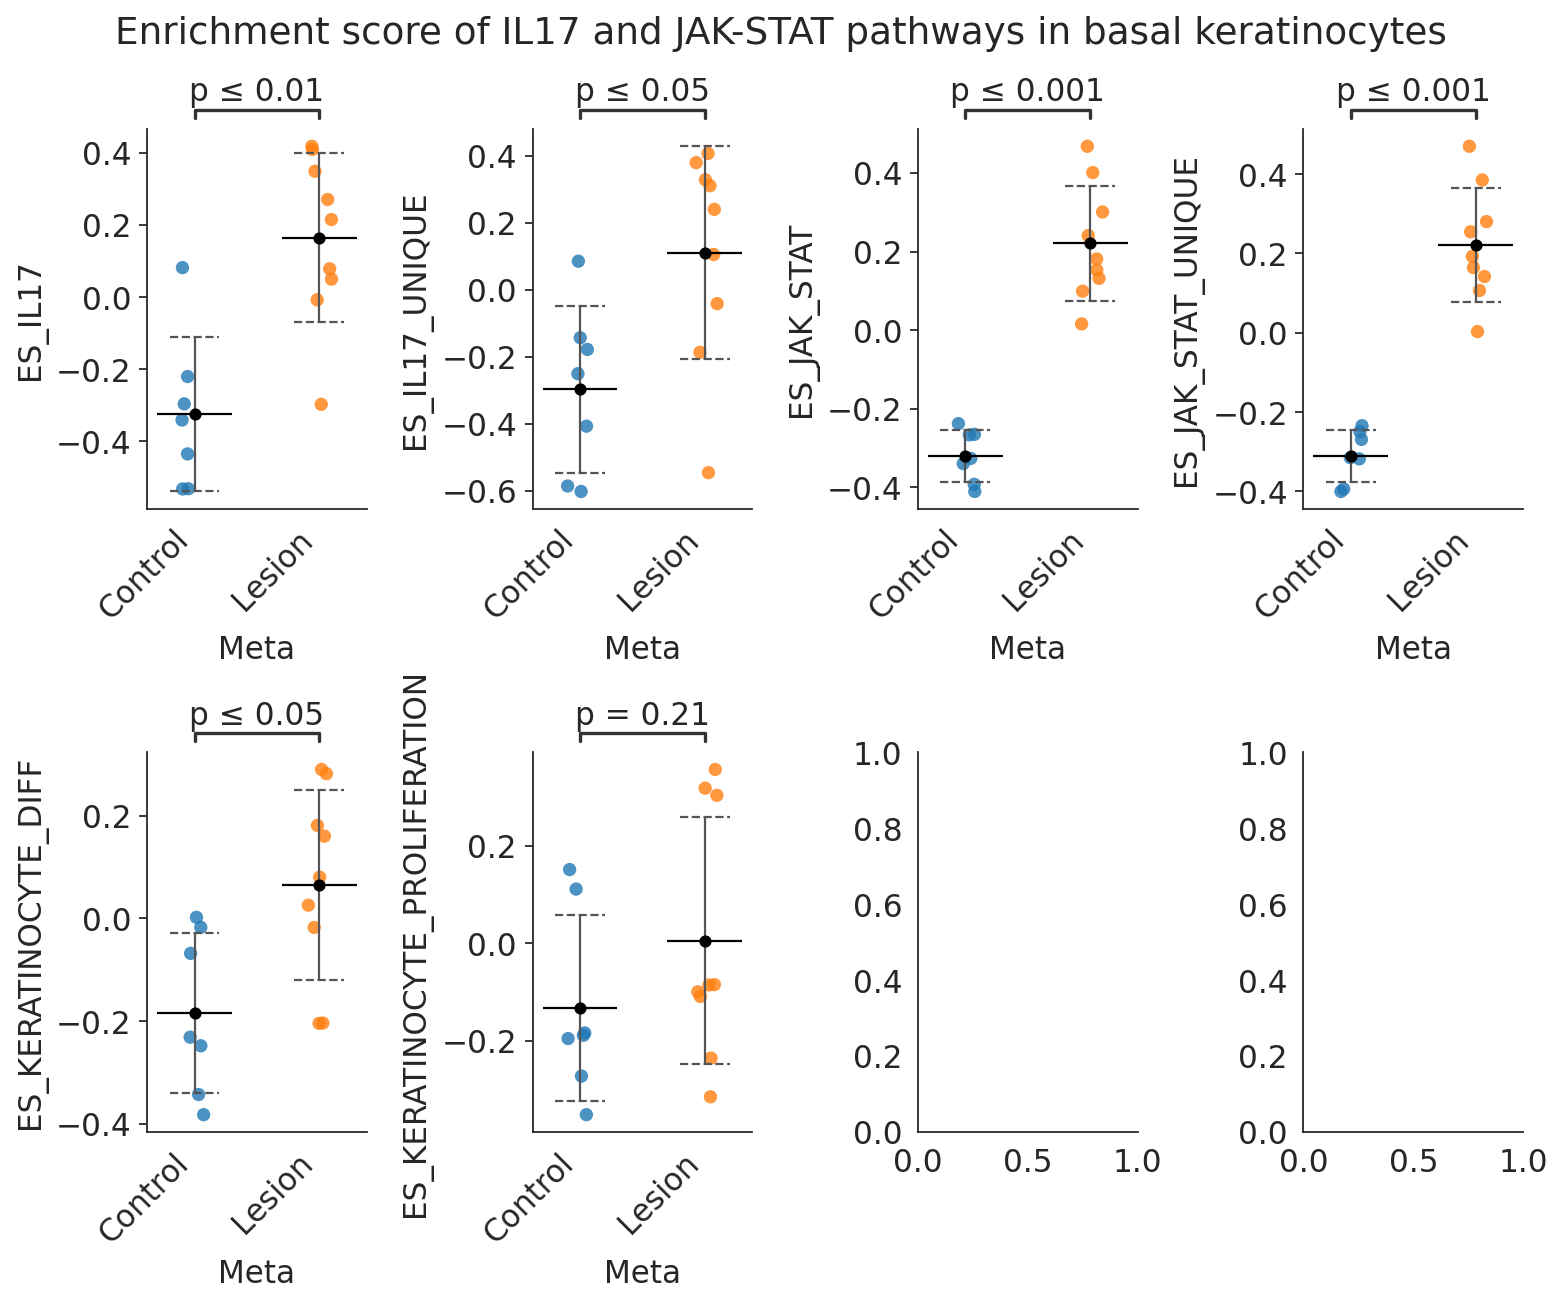

In [ ]:
order = ['Control', 'Lesion']
pairs = [('Control', 'Lesion')]

def plot_es(df, col_list, suptitle, path=None):
    nrows = np.ceil(len(col_list) / 4).astype(int)
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(10, 4*nrows))
    
    for i, col in enumerate(col_list):
        df[col] = df[col].astype(float)
        lesion_sd = df[df['Meta'] == 'Lesion'][col].std()
        lesion_mean = df[df['Meta'] == 'Lesion'][col].mean()
        normal_sd = df[df['Meta'] == 'Control'][col].std()
        normal_mean = df[df['Meta'] == 'Control'][col].mean()

        sns.stripplot(data=df, x='Meta', y=col, palette='tab10', size=6, jitter=True, alpha=0.8, order=['Control', 'Lesion'],
                           ax=ax[i//4, i%4])

        ax[i//4, i%4].hlines(lesion_mean, 0.7, 1.3, color='black', linestyle='-', lw=1, zorder=10)
        ax[i//4, i%4].hlines(normal_mean, -0.3, 0.3, color='black', linestyle='-', lw=1, zorder=10)
        ax[i//4, i%4].hlines(lesion_mean + lesion_sd, 0.8, 1.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].hlines(lesion_mean - lesion_sd, 0.8, 1.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].hlines(normal_mean + normal_sd, -0.2, 0.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].hlines(normal_mean - normal_sd, -0.2, 0.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].vlines(1, lesion_mean - lesion_sd, lesion_mean + lesion_sd, color='#545457', linestyle='-', lw=1, zorder=10)
        ax[i//4, i%4].vlines(0, normal_mean - normal_sd, normal_mean + normal_sd, color='#545457', linestyle='-', lw=1, zorder=10)
        
        ax[i//4, i%4].scatter([0, 1], [normal_mean, lesion_mean], color='black', s=20, zorder=10)
        ax[i//4, i%4].yaxis.set_ticks_position('left')

        ax[i//4, i%4].set_xticklabels(ax[i//4, i%4].get_xticklabels(), rotation=45, horizontalalignment='right')
        annotator = Annotator(ax[i//4, i%4], pairs=pairs, data=df, x='Meta', y=col, order=order)
        annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
        annotator.apply_and_annotate()
    
    sns.despine()
    fig.tight_layout()
    fig.suptitle(suptitle, y=1.02)
    if path:
        plt.savefig(path, bbox_inches='tight')

plot_es(merged_df, ['ES_IL17', 'ES_IL17_UNIQUE', 'ES_JAK_STAT', 'ES_JAK_STAT_UNIQUE', 'ES_KERATINOCYTE_DIFF', 'ES_KERATINOCYTE_PROLIFERATION'],
        'Enrichment score of IL17 and JAK-STAT pathways in basal keratinocytes', 
        'figures/fig2_6/enrichment_score_IL17_JAK_STAT_basal_keratinocytes.pdf')

### Suprabasal cell gsva

In [ ]:
msig = Msigdb()
gmt_go_bp = msig.get_gmt(category="c5.go.bp", dbver='2023.2.Hs')
gmt_hallmark = msig.get_gmt(category="h.all", dbver='2023.2.Hs')

il17_pathway_set = {'GOBP_RESPONSE_TO_INTERLEUKIN_17': gmt_go_bp['GOBP_RESPONSE_TO_INTERLEUKIN_17']}
jak_stat_pathway_set = {'HALLMARK_IL6_JAK_STAT3_SIGNALING': gmt_hallmark['HALLMARK_IL6_JAK_STAT3_SIGNALING']}

intersect_genes = set(il17_pathway_set['GOBP_RESPONSE_TO_INTERLEUKIN_17']) & set(jak_stat_pathway_set['HALLMARK_IL6_JAK_STAT3_SIGNALING'])

il17_pathway_set_unique = {'GOBP_RESPONSE_TO_INTERLEUKIN_17_UNIQUE': list(set(il17_pathway_set['GOBP_RESPONSE_TO_INTERLEUKIN_17']) - intersect_genes)}
jak_stat_pathway_set_unique = {'HALLMARK_IL6_JAK_STAT3_SIGNALING_UNIQUE': list(set(jak_stat_pathway_set['HALLMARK_IL6_JAK_STAT3_SIGNALING']) - intersect_genes)}

# GOBP_KERATINOCYTE_DIFFERENTIATION
keratinocyte_diff_pathway_set = {'GOBP_KERATINOCYTE_DIFFERENTIATION': gmt_go_bp['GOBP_KERATINOCYTE_DIFFERENTIATION']}
# GOBP_KERATINOCYTE_PROLIFERATION
keratinocyte_proliferation_pathway_set = {'GOBP_KERATINOCYTE_PROLIFERATION': gmt_go_bp['GOBP_KERATINOCYTE_PROLIFERATION']}

es_il17 = gp.gsva(data=suprabasal_cell.to_df().T, # row -> genes, column-> samples
             gene_sets=il17_pathway_set,
             outdir=None,
             min_size=3,
            #  mx_diff=False,
             )

es_il17_unique = gp.gsva(data=suprabasal_cell.to_df().T, # row -> genes, column-> samples
             gene_sets=il17_pathway_set_unique,
             outdir=None,
             min_size=1,
            #  mx_diff=False,
             )

es_jak_stat = gp.gsva(data=suprabasal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=jak_stat_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

es_jak_stat_unique = gp.gsva(data=suprabasal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=jak_stat_pathway_set_unique,
                outdir=None,
                # mx_diff=False,
                )

es_keratinocyte_diff = gp.gsva(data=suprabasal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=keratinocyte_diff_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

es_keratinocyte_proliferation = gp.gsva(data=suprabasal_cell.to_df().T, # row -> genes, column-> samples
                gene_sets=keratinocyte_proliferation_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

df_list = []
df_list.append(es_il17.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_IL17'}))
df_list.append(es_il17_unique.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_IL17_UNIQUE'}))
df_list.append(es_jak_stat.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_JAK_STAT'}))
df_list.append(es_jak_stat_unique.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_JAK_STAT_UNIQUE'}))
df_list.append(es_keratinocyte_diff.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_KERATINOCYTE_DIFF'}))
df_list.append(es_keratinocyte_proliferation.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_KERATINOCYTE_PROLIFERATION'}))

merged_df = pd.concat(df_list, axis=1, join='outer')
merged_df = merged_df.join(suprabasal_cell.obs, how='left')
# merged_df

/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.322e-03 U_stat=5.000e+00


/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00
Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.993e-04 U_stat=2.000e+00


/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:5.490e-02 U_stat=1.300e+01


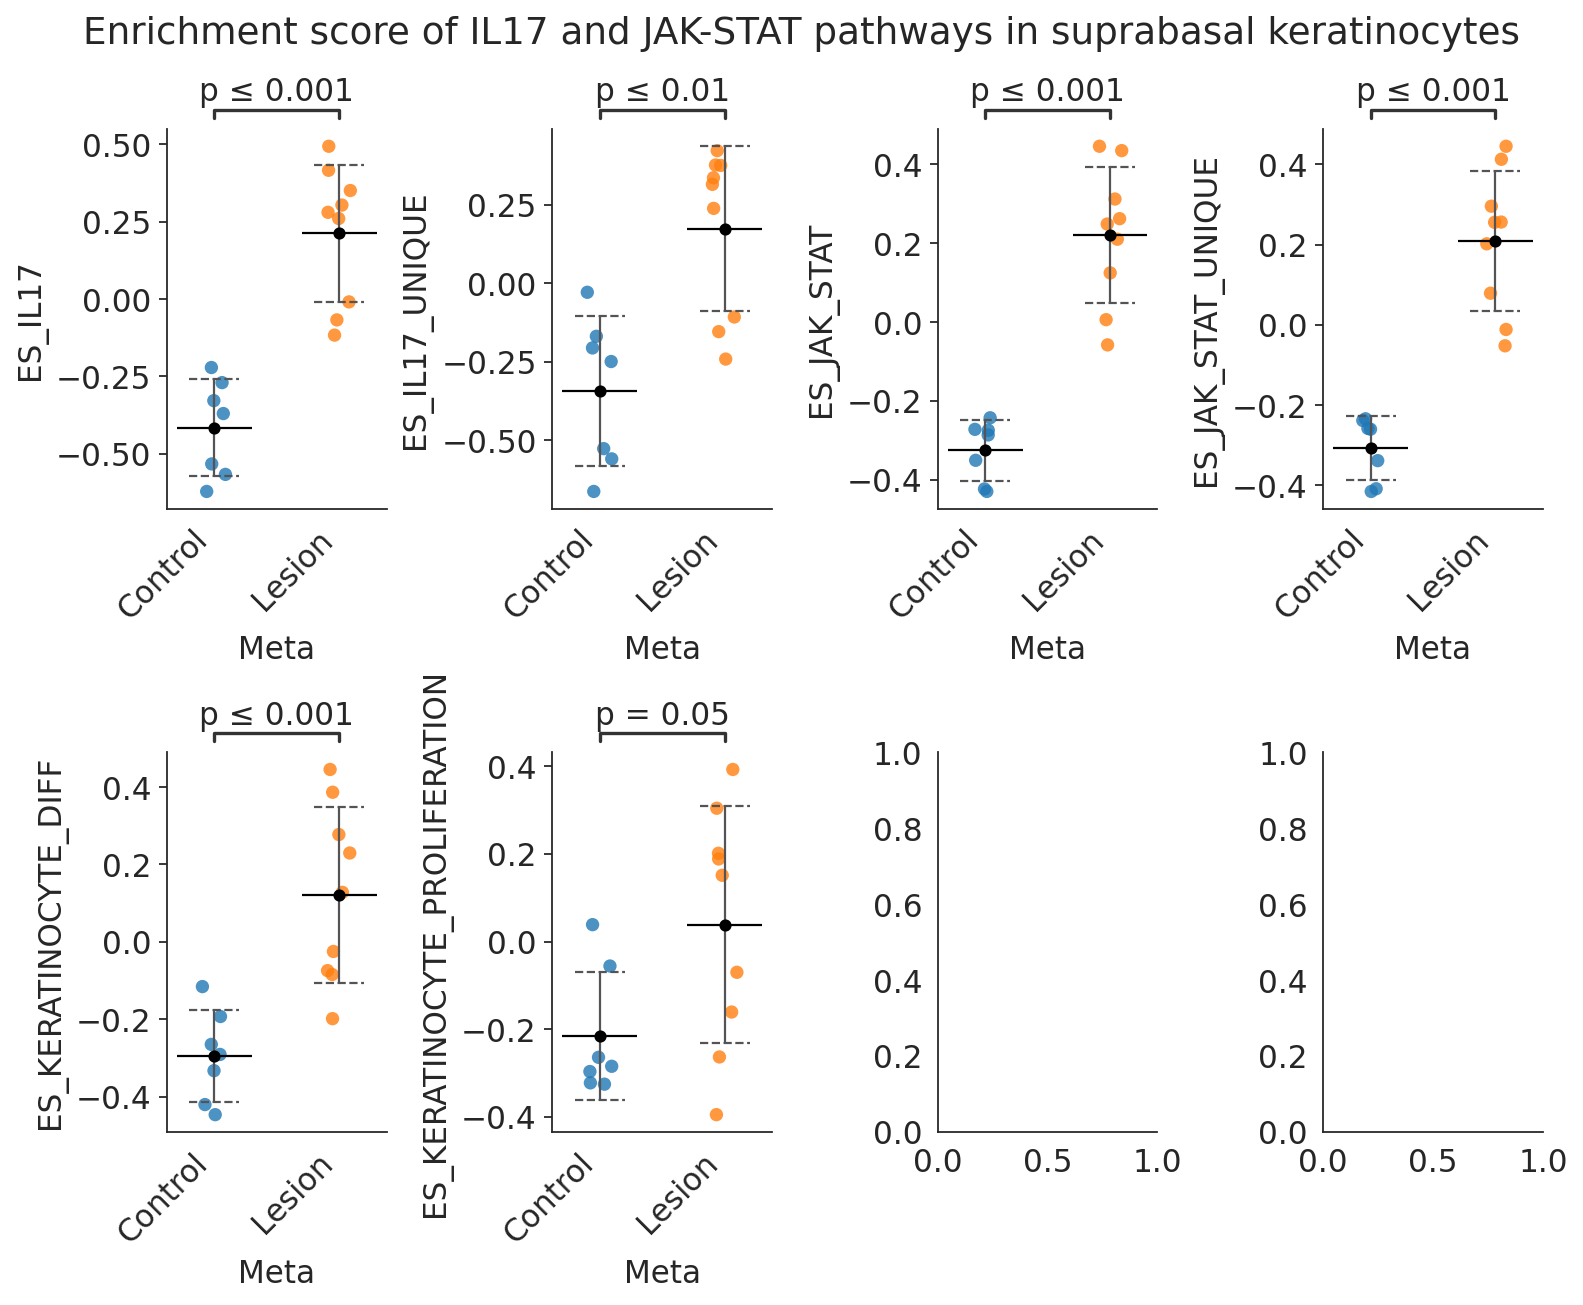

In [ ]:
plot_es(merged_df, ['ES_IL17', 'ES_IL17_UNIQUE', 'ES_JAK_STAT', 'ES_JAK_STAT_UNIQUE', 'ES_KERATINOCYTE_DIFF', 'ES_KERATINOCYTE_PROLIFERATION'],
        'Enrichment score of IL17 and JAK-STAT pathways in suprabasal keratinocytes',
        'figures/fig2_6/enrichment_score_IL17_JAK_STAT_suprabasal.pdf')

/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:9.073e-02 U_stat=4.800e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.065e-01 U_stat=3.700e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.523e-01 U_stat=4.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:7.867e-03 U_stat=5.600e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=6.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.523e-01 U_stat=4.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.224e-03 U_stat=3.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:5.490e-02 U_stat=1.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.290e-02 U_stat=1.000e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.806e-01 U_stat=2.700e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:4.698e-01 U_stat=3.900e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.497e-04 U_stat=1.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.377e-02 U_stat=1.350e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.142e-01 U_stat=1.600e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.322e-03 U_stat=5.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.325e-01 U_stat=1.700e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.989e-02 U_stat=1.050e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.290e-02 U_stat=1.000e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:7.867e-03 U_stat=7.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.112e-02 U_stat=1.100e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.135e-01 U_stat=3.600e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:4.497e-01 U_stat=2.800e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.247e-02 U_stat=1.000e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.012e-01 U_stat=2.250e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.200e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.290e-02 U_stat=1.000e+01


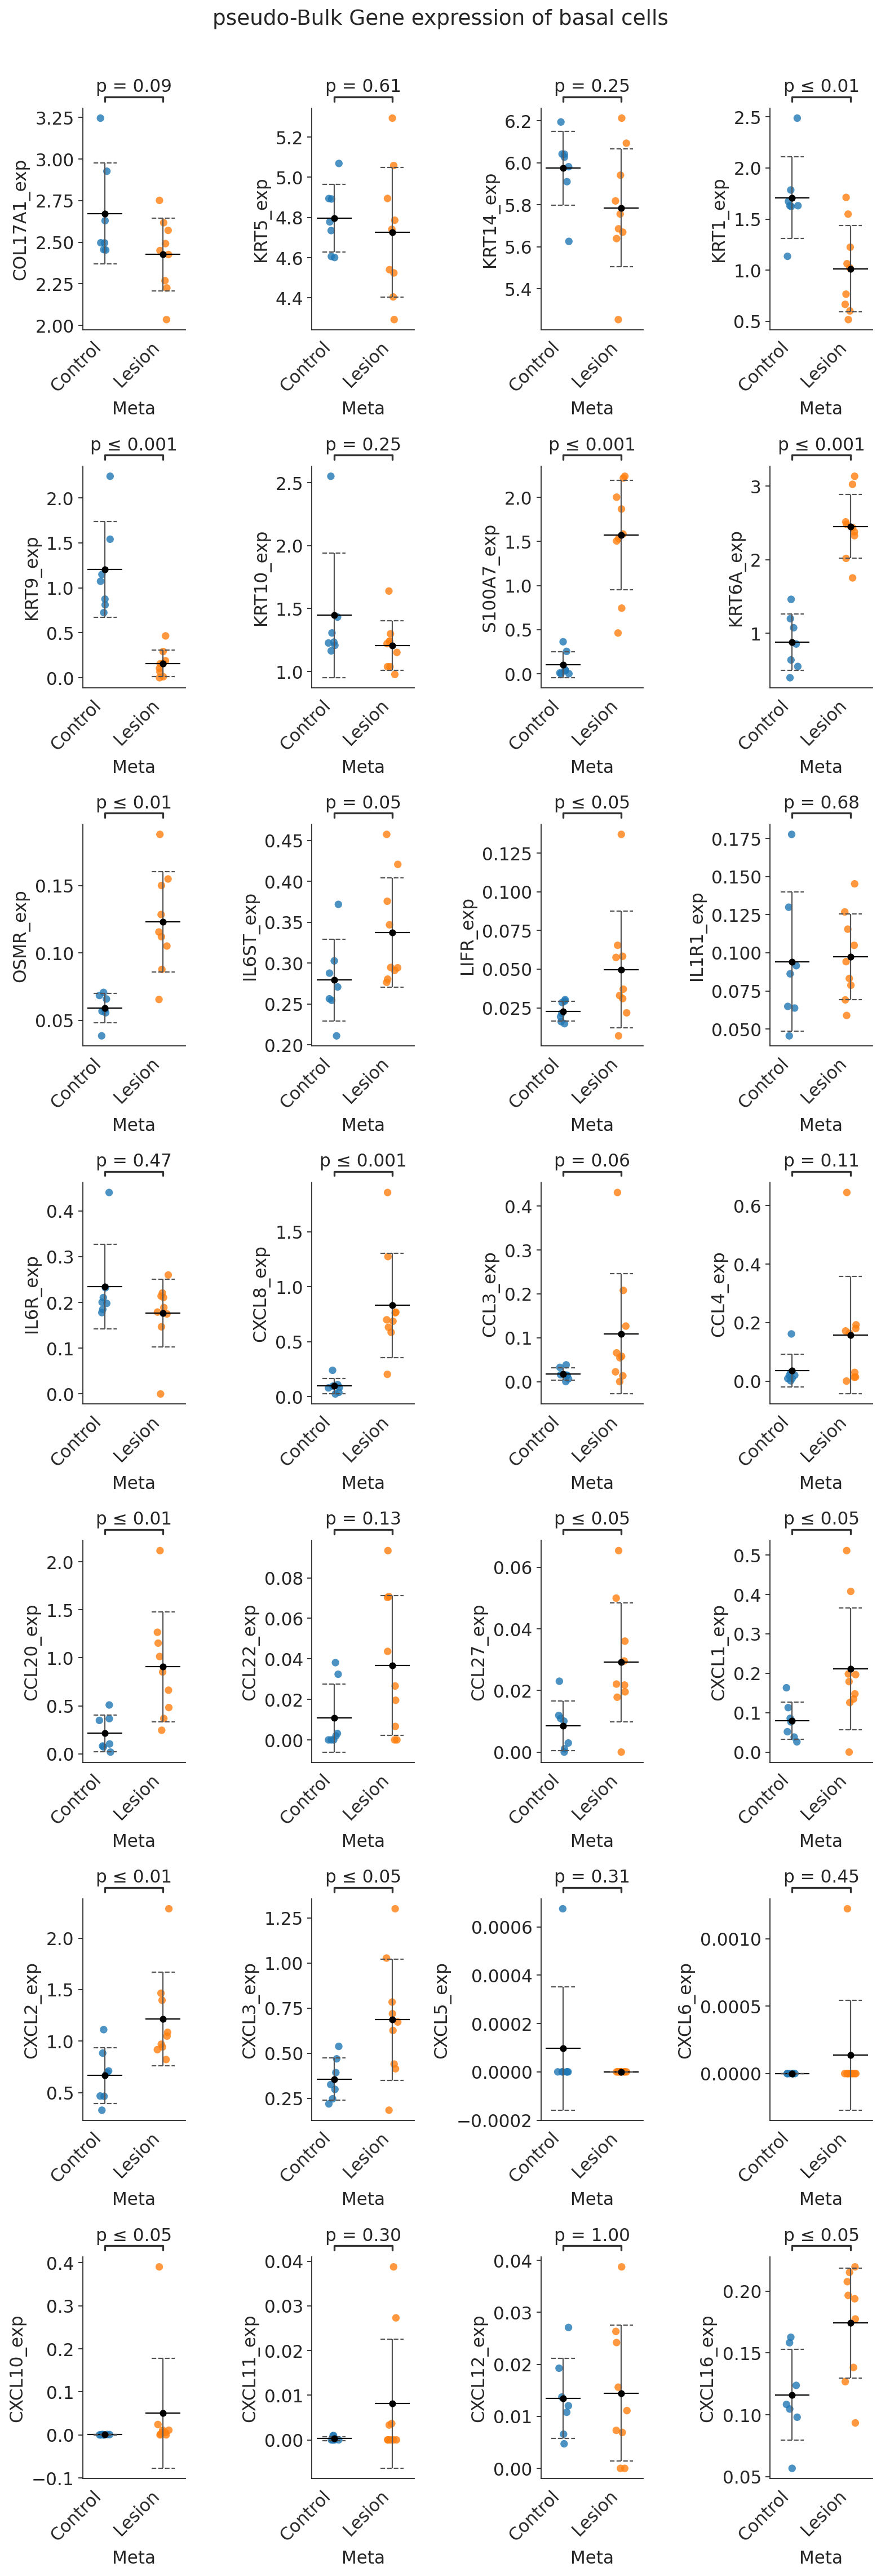

In [ ]:
gene_list = ['COL17A1', 'KRT5', 'KRT14', 'KRT1', 'KRT9', 'KRT10', 
             'S100A7', 'KRT6A', 'OSMR', 'IL6ST', 'LIFR', 'IL1R1', 'IL6R', 
             'CXCL8', 'CCL3', 'CCL4', 'CCL20', 'CCL22', 'CCL27', 'CXCL1',
                'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL10', 'CXCL11', 'CXCL12',
                 'CXCL16']

for gene in gene_list:
    pdata.obs[f"{gene}_exp"] = pdata[:, gene].X.toarray().flatten()

basal_cell = pdata[pdata.obs['cell_type'] == 'Basal']
suprabasal_cell = pdata[pdata.obs['cell_type'] == 'Suprabasal']

plot_es(basal_cell.obs, [x+"_exp" for x in gene_list],
        'pseudo-Bulk Gene expression of basal cells',
        'figures/fig2_6/pseudobulk_gene_expression_basal.pdf') 

/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:9.182e-01 U_stat=3.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.112e-02 U_stat=1.100e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:9.073e-02 U_stat=1.500e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.098e-03 U_stat=5.900e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=6.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:8.371e-01 U_stat=3.400e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:9.073e-02 U_stat=1.500e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.718e-01 U_stat=3.600e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.065e-01 U_stat=2.600e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:5.490e-02 U_stat=1.300e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=0.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.643e-02 U_stat=9.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:5.245e-03 U_stat=6.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:2.098e-03 U_stat=4.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.011e-01 U_stat=1.650e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.657e-01 U_stat=4.000e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:4.178e-02 U_stat=1.200e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.224e-03 U_stat=3.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.497e-04 U_stat=1.000e+00


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.413e-01 U_stat=2.800e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.150e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:6.413e-01 U_stat=2.800e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:4.497e-01 U_stat=2.800e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.336e-01 U_stat=4.100e+01


/tmp/ipykernel_2992619/2078813679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[col] = df[col].astype(float)
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Control vs. Lesion: Mann-Whitney-Wilcoxon test two-sided, P_val:3.497e-04 U_stat=1.000e+00


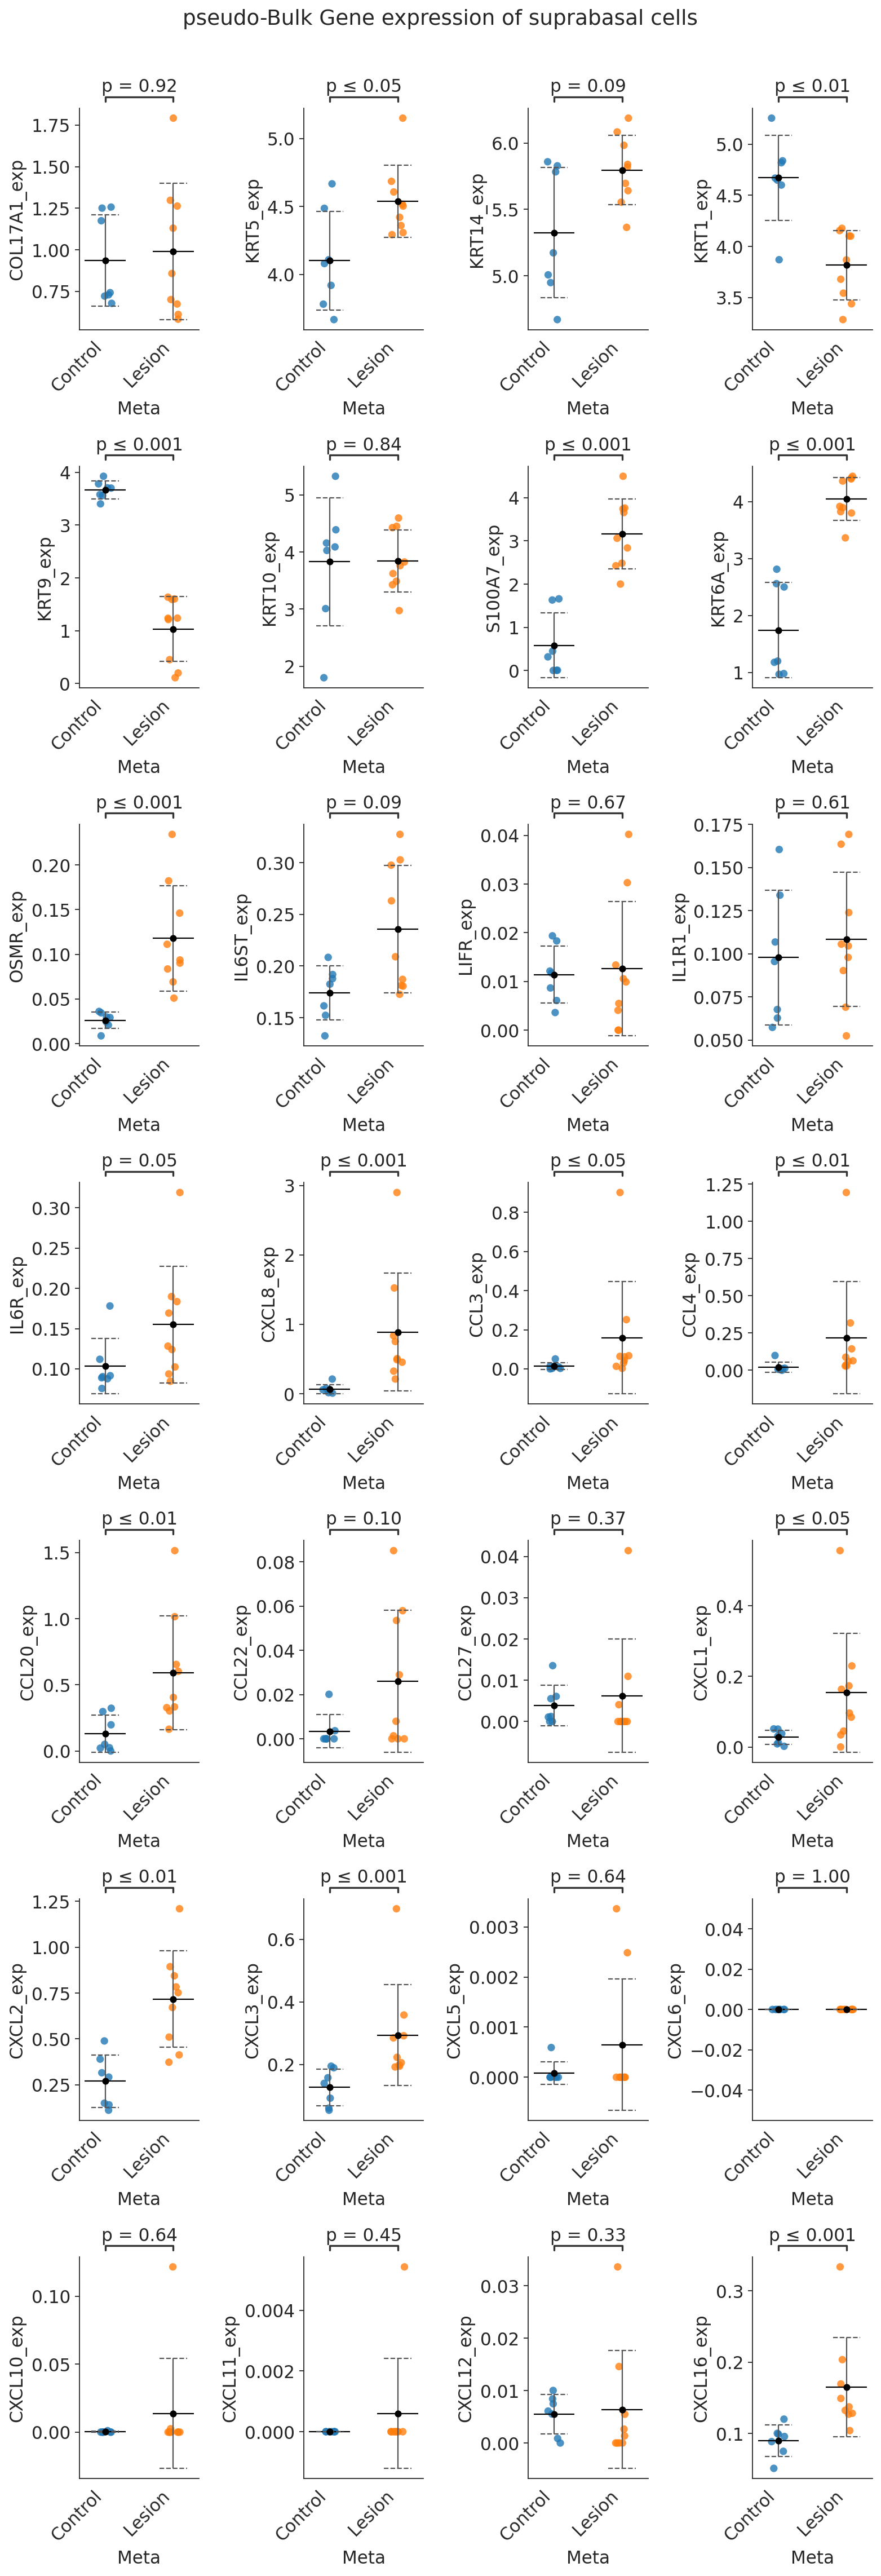

In [ ]:
plot_es(suprabasal_cell.obs, [x+"_exp" for x in gene_list],
        'pseudo-Bulk Gene expression of suprabasal cells',
        'figures/fig2_6/pseudobulk_gene_expression_suprabasal.pdf') 

### pseudo bulk by leiden

In [11]:
pdata = dc.get_pseudobulk(
    adata_ker,
    sample_col='batch',
    groups_col='leiden',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

In [12]:
pdata.layers['counts'] = pdata.X.copy()

sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

normalizing counts per cell
    finished (0:00:00)


In [13]:
pdata.obs['CXCL8_exp'] = pdata[:, 'CXCL8'].X.toarray().flatten()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


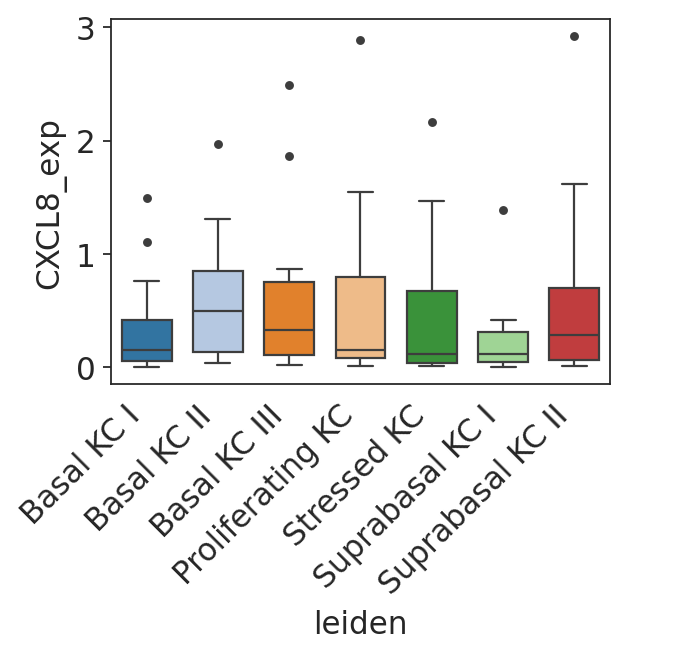

In [15]:
with rc_context({'figure.figsize': (4, 3)}):
    order = list(pdata.obs.leiden.unique())
    g = sns.boxplot(data=pdata.obs, x='leiden', y='CXCL8_exp', flierprops={"marker": "o", "alpha": 1, "markersize": 3}, palette=sns.palettes.color_palette((adata_ker.uns['leiden_colors'])), \
        order=order, width=0.7, linewidth=1)
    g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.yaxis.set_ticks_position('left')

    # sns.despine()
    # pairs = [('Neutrophil', 'PPP neutrophil')]

    # annotator = Annotator(g, pairs=pairs, data=pdata.obs, x='leiden', y='CXCL8_exp', order=order)
    # annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
    # annotator.apply_and_annotate()
    
    # plt.savefig('figures/fig4_2/OSM_exp_in_neutrophil.pdf', bbox_inches='tight')

In [ ]:
msig = Msigdb()
gmt_go_bp = msig.get_gmt(category="c5.go.bp", dbver='2023.2.Hs')
gmt_hallmark = msig.get_gmt(category="h.all", dbver='2023.2.Hs')

il17_pathway_set = {'GOBP_RESPONSE_TO_INTERLEUKIN_17': gmt_go_bp['GOBP_RESPONSE_TO_INTERLEUKIN_17']}
jak_stat_pathway_set = {'HALLMARK_IL6_JAK_STAT3_SIGNALING': gmt_hallmark['HALLMARK_IL6_JAK_STAT3_SIGNALING']}

es_jak_stat = gp.gsva(data=pdata.to_df().T, # row -> genes, column-> samples
                gene_sets=jak_stat_pathway_set,
                outdir=None,
                # mx_diff=False,
                )

df_list = []
df_list.append(es_jak_stat.res2d.set_index('Name').loc[:,['ES']].rename(columns={'ES': 'ES_JAK_STAT'}))

merged_df = pd.concat(df_list, axis=1, join='outer')
merged_df = merged_df.join(pdata.obs, how='left')
# merged_df

In [ ]:
merged_df

,ES_JAK_STAT,batch,batch_origin,batch_group,Meta,is_P36,is_C02_palm,is_C02_foot,is_P40,is_P29,is_P23,leiden,patient,cell_type,meta_cell_type,batch_group_cell_type,psbulk_n_cells,psbulk_counts
Name,,,,,,,,,,,,,,,,,,
HC_HC01_foot_10X_Basal KC I,0.000662,HC_HC01_foot_10X,foot,HC,Control,False,False,False,False,False,False,Basal KC I,HC_HC01,Basal,Control_Basal,HC_Basal,11.0,159747.0
PPPC_P39C_palm_10X_Stressed KC,-0.281778,PPPC_P39C_palm_10X,palm,NL,Control,False,False,False,False,False,False,Stressed KC,PPPC_P39,Stressed,Control_Stressed,NL_Stressed,205.0,1553471.0
PPPC_P37C1_palm_10X_Suprabasal KC I,-0.35607,PPPC_P37C1_palm_10X,palm,NL,Control,False,False,False,False,False,False,Suprabasal KC I,PPPC_P37,Suprabasal,Control_Suprabasal,NL_Suprabasal,331.0,4486583.0
HC_HC02_palm_10X_Suprabasal KC I,-0.426435,HC_HC02_palm_10X,palm,HC,Control,False,True,False,False,False,False,Suprabasal KC I,HC_HC02,Suprabasal,Control_Suprabasal,HC_Suprabasal,1546.0,13902306.0
HC_HC01_foot_10X_Suprabasal KC I,-0.327821,HC_HC01_foot_10X,foot,HC,Control,False,False,False,False,False,False,Suprabasal KC I,HC_HC01,Suprabasal,Control_Suprabasal,HC_Suprabasal,55.0,866986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HC_HC02_palm_10X_Basal KC III,-0.076042,HC_HC02_palm_10X,palm,HC,Control,False,True,False,False,False,False,Basal KC III,HC_HC02,Basal,Control_Basal,HC_Basal,237.0,386244.0
PPP_P40_palm_10X_Basal KC II,0.347565,PPP_P40_palm_10X,palm,Lesion,Lesion,False,False,False,True,False,False,Basal KC II,PPP_P40,Basal,Lesion_Basal,Lesion_Basal,203.0,3318843.0
PPP_P39_palm_10X_Basal KC II,0.41553,PPP_P39_palm_10X,palm,Lesion,Lesion,False,False,False,False,False,False,Basal KC II,PPP_P39,Basal,Lesion_Basal,Lesion_Basal,143.0,2182860.0


In [ ]:
merged_df['ES_JAK_STAT'] = merged_df['ES_JAK_STAT'].astype(float)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Suprabasal KC I vs. Suprabasal KC II: Mann-Whitney-Wilcoxon test two-sided, P_val:3.228e-02 U_stat=6.000e+01


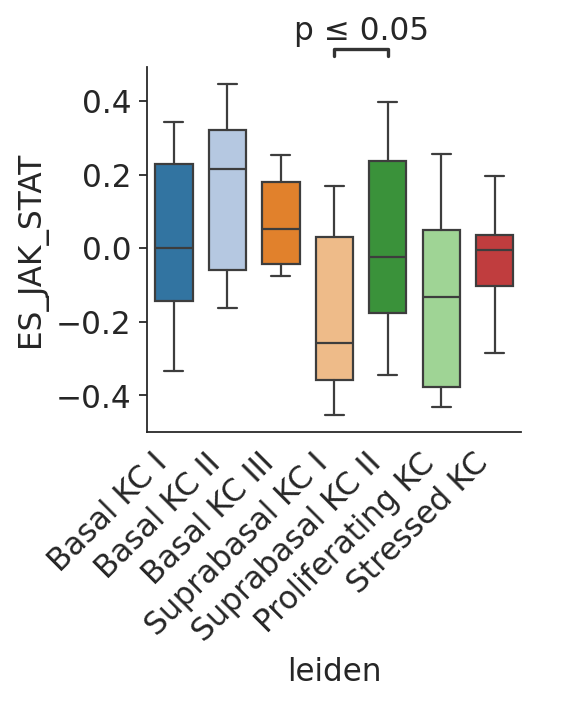

In [ ]:
with rc_context({'figure.figsize': (3, 3)}):
    order = ['Basal KC I', 'Basal KC II', 'Basal KC III', 'Suprabasal KC I', 'Suprabasal KC II', 'Proliferating KC', 'Stressed KC']
    merged_df
    g = sns.boxplot(data=merged_df, x='leiden', y='ES_JAK_STAT', flierprops={"marker": "o", "alpha": 1, "markersize": 3}, palette=sns.palettes.color_palette((adata_ker.uns['leiden_colors'])), \
        order=order, width=0.7, linewidth=1)
    g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

    pairs = [('Suprabasal KC I', 'Suprabasal KC II')]

    annotator = Annotator(g, pairs=pairs, data=merged_df, x='leiden', y='ES_JAK_STAT', order=order)
    annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
    annotator.apply_and_annotate()

    sns.despine()
    g.yaxis.set_ticks_position('left')
    plt.savefig('figures/fig2_6/enrichment_score_JAK_STAT_pathway.pdf', bbox_inches='tight')